In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime

In [2]:
%run Visulaization_Utils.ipynb

In [3]:
data_path = './Data/'
data_name_lst = [name for name in os.listdir(data_path) if name.startswith('Fill')]
data_name_lst

['FillByAll4_2018_.csv',
 'FillByAll4_2019_.csv',
 'FillByAll4_2020_.csv',
 'FillByAll4_2021_.csv',
 'FillByAll4_2022_.csv']

In [25]:
PM_data = {i.split('_')[1]: pd.read_csv(os.path.join(data_path, i)) for i in data_name_lst}

## Test with one year

In [5]:
label_path = './check_station_per_provide.csv'
label_df = meteorology_labeling(label_path)
label_dict = match_label_station(PM_data['2018'], label_df)

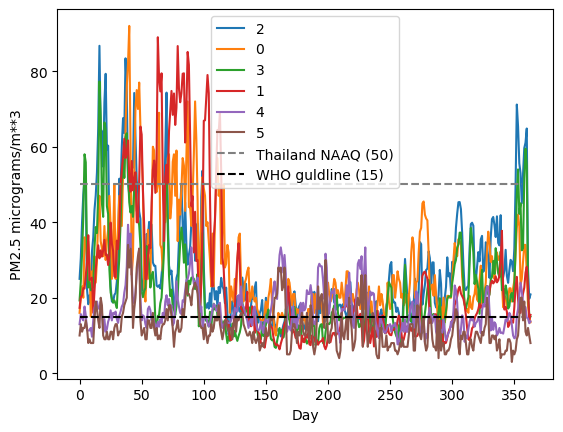

In [6]:
plot_PM_mean_curve(label_dict)

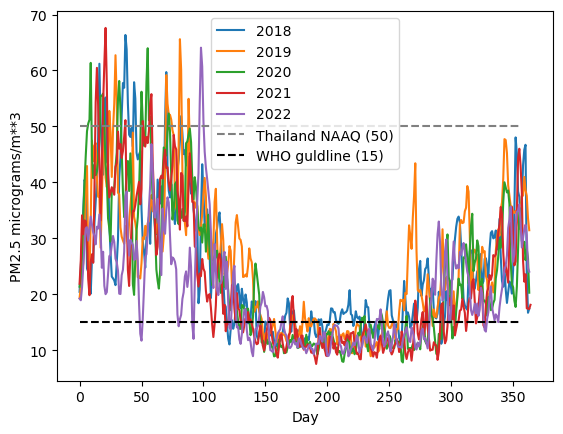

In [7]:
plot_PM_mean_curve(PM_data)

### Time series decomposition plot

In [8]:
def merge_all_year_as_timeseries(PM_data):
    all_year = pd.DataFrame(columns=['Date', 'Mean PM2.5'])
    for key, df in PM_data.items():
        mean_data = df.mean(axis=1, numeric_only=True)
        a_year_df = pd.DataFrame(df['Date'].copy().to_list(), columns=['Date'])
        a_year_df['Mean PM2.5'] = mean_data.copy().to_list()
        all_year = pd.concat([all_year, a_year_df], axis=0)

    # Add some detail
    all_year = all_year.reset_index().drop(columns=['index'])
    all_year['Date'] = all_year['Date'].apply(lambda x : datetime.strptime(x, '%Y_%m_%d'))
    all_year = all_year.drop_duplicates()
    all_year = all_year.set_index('Date').asfreq(freq='D')
    all_year['Mean PM2.5'] = all_year['Mean PM2.5'].interpolate('linear')
    return all_year

In [9]:
TS_PM_data = merge_all_year_as_timeseries(PM_data)
TS_PM_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2018-01-01 to 2022-12-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Mean PM2.5  1826 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


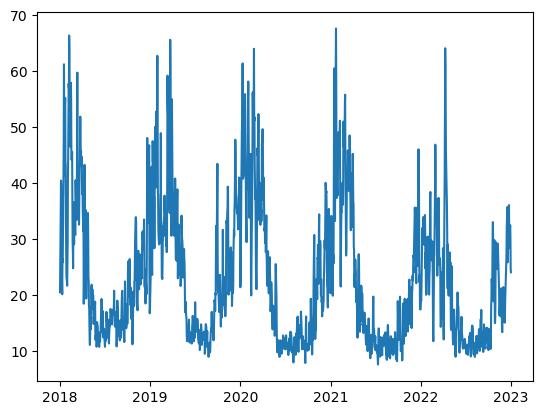

In [10]:
plt.plot(TS_PM_data.index, TS_PM_data['Mean PM2.5'])

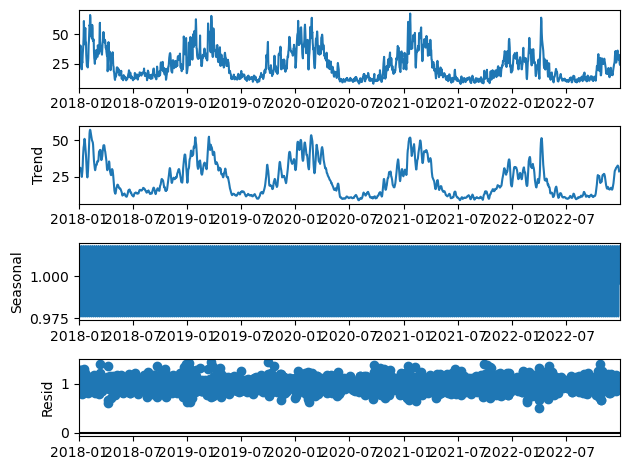

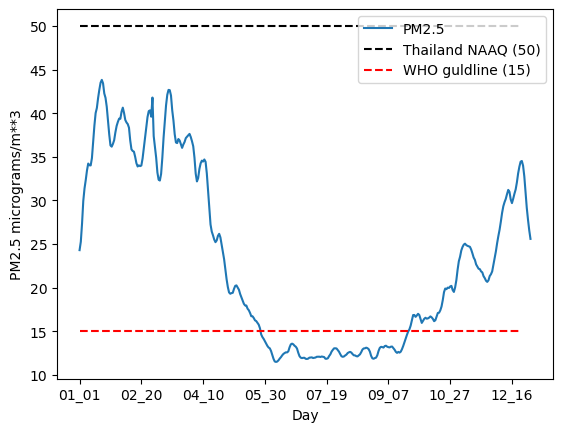

In [11]:
plot_TS_all_year(TS_PM_data, plot_result=True)

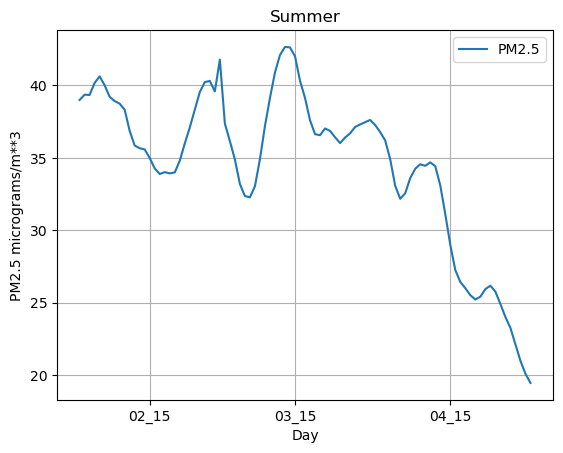

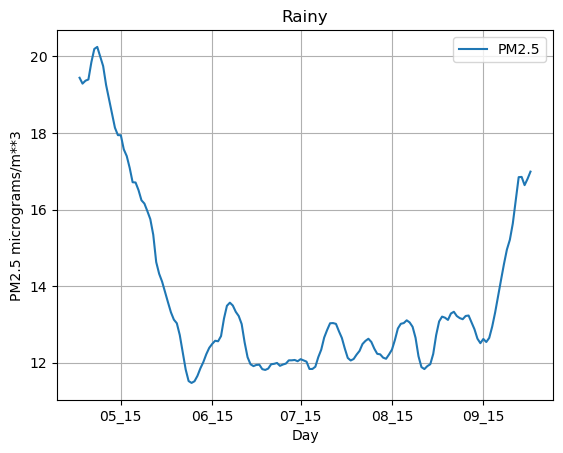

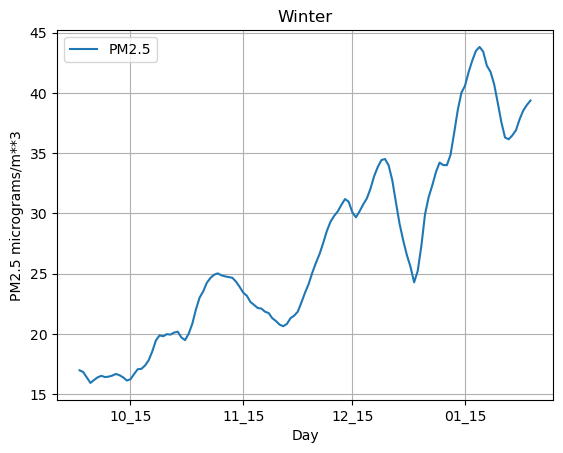

In [12]:
plot_TS_3_seasons(TS_PM_data)

### Ratio plot

In [13]:
cond_lst = [0, 50, 100, 150, np.inf]
mean_per_month_df = a_year_pollution_ratio(PM_data['2018'].copy(), cond_lst)

In [14]:
mean_per_month_df

,Month,0<=x<50,50<=x<100,100<=x<150,150<=x<inf
0,01,0.800974,0.189897,0.009130,0.0
1,02,0.633423,0.363881,0.002695,0.0
2,03,0.678028,0.312842,0.009130,0.0
3,04,0.876730,0.123270,0.000000,0.0
4,05,1.000000,0.000000,0.000000,0.0
5,06,1.000000,0.000000,0.000000,0.0
6,07,1.000000,0.000000,0.000000,0.0
7,08,0.995131,0.004869,0.000000,0.0
8,09,0.997484,0.002516,0.000000,0.0
9,10,0.990262,0.009738,0.000000,0.0


Text(0.5, 0, 'Month')

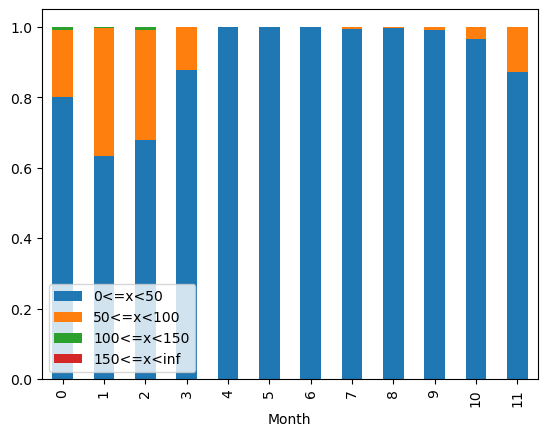

In [15]:
mean_per_month_df.plot.bar(stacked=True)
plt.xlabel('Month')

## Test with multi years

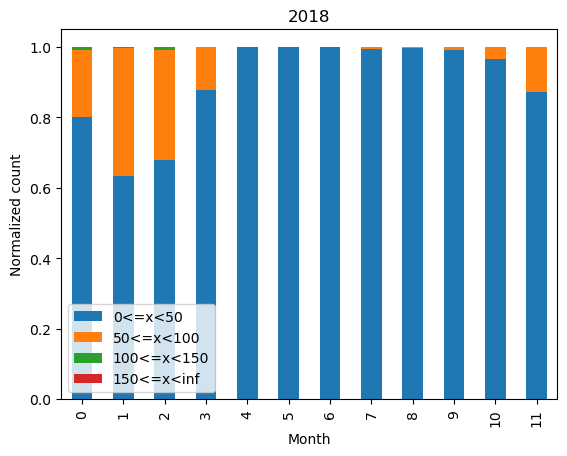

<Figure size 640x480 with 0 Axes>

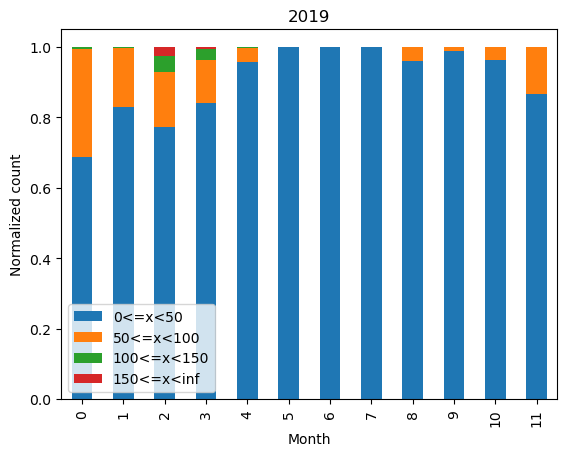

<Figure size 640x480 with 0 Axes>

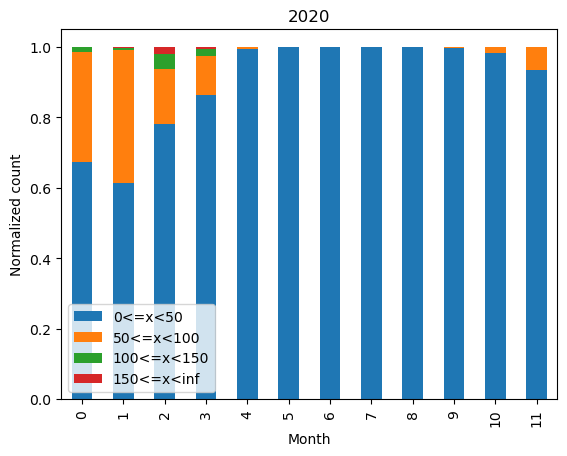

<Figure size 640x480 with 0 Axes>

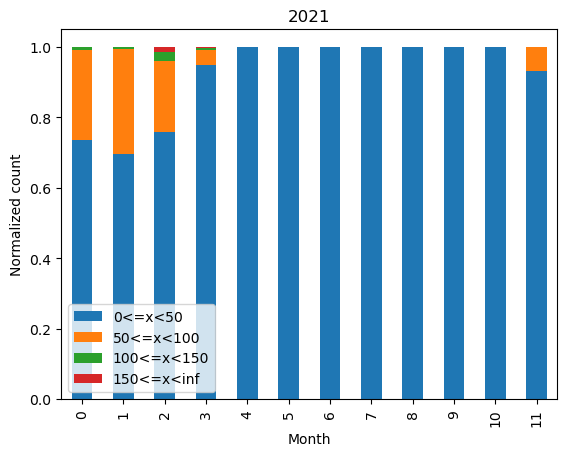

<Figure size 640x480 with 0 Axes>

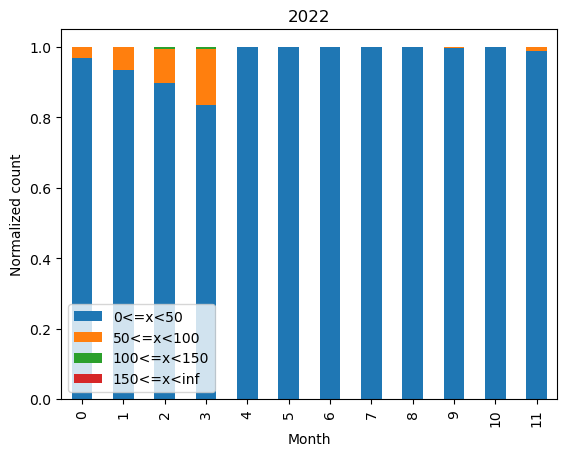

<Figure size 640x480 with 0 Axes>

In [16]:
cond_lst = [0, 50, 100, 150, np.inf]
a = []
for year, df in PM_data.items():
    mean_per_month_df = a_year_pollution_ratio(df.copy(), cond_lst)
    a.append(mean_per_month_df.copy().drop(columns=['Month']))
    mean_per_month_df.plot.bar(stacked=True)
    plt.title(year)
    plt.xlabel('Month')
    plt.ylabel('Normalized count')
    plt.pause(0.001)
    plt.clf()

month_df = pd.DataFrame(mean_per_month_df['Month'].to_list(), columns=['Month'])

In [17]:
col_name = a[0].columns
d = 0
for i in a:
    d += i.to_numpy()
d = d / len(a)
all_year_bar_df = pd.concat([month_df, pd.DataFrame(d, columns=col_name)], axis=1)

Text(0, 0.5, 'Normalized count')

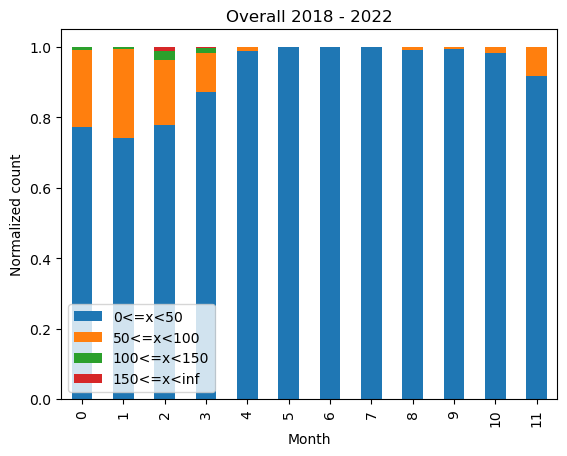

In [18]:
all_year_bar_df.plot.bar(stacked=True)
plt.title('Overall 2018 - 2022')
plt.xlabel('Month')
plt.ylabel('Normalized count')

## Result

In [19]:
data_path = './Data/'
data_name_lst = [name for name in os.listdir(data_path) if name.startswith('Fill')]
data_name_lst

PM_data = {i.split('_')[1]: pd.read_csv(os.path.join(data_path, i)) for i in data_name_lst}
TS_PM_data = merge_all_year_as_timeseries(PM_data)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2018-01-01 to 2022-12-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Mean PM2.5  1826 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


Text(0, 0.5, 'Normalized count')

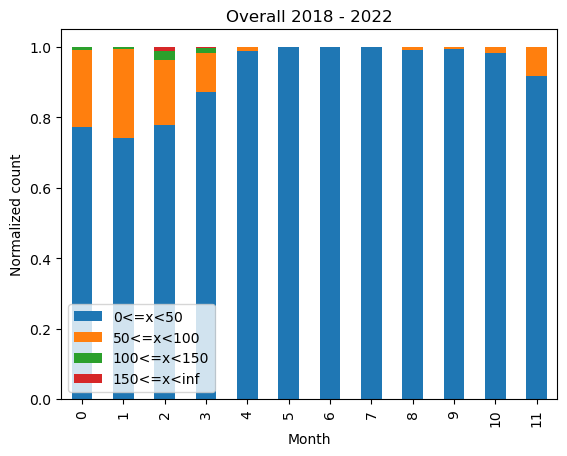

In [20]:
all_year_bar_df.plot.bar(stacked=True)
plt.title('Overall 2018 - 2022')
plt.xlabel('Month')
plt.ylabel('Normalized count')

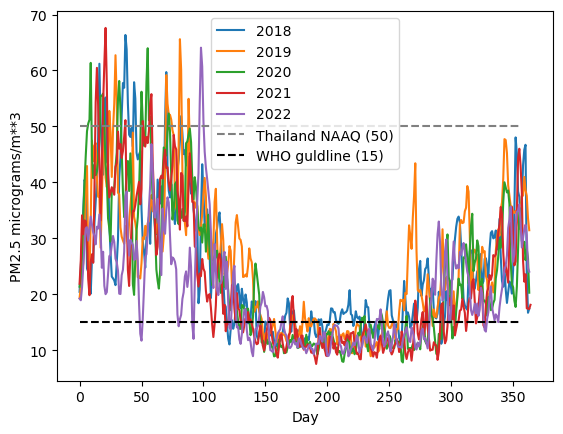

In [21]:
plot_PM_mean_curve(PM_data)

When be seperated by Thailand sector
Year:  2018


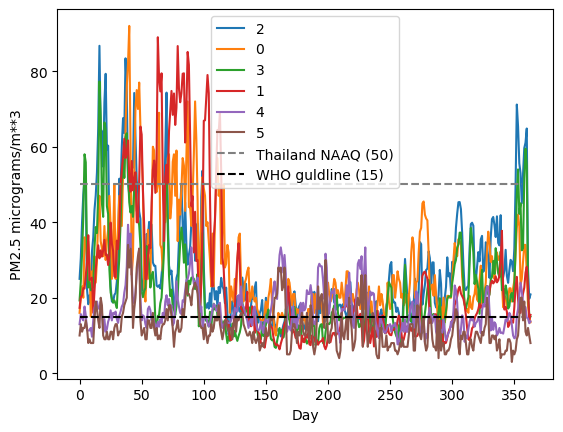

Year:  2019


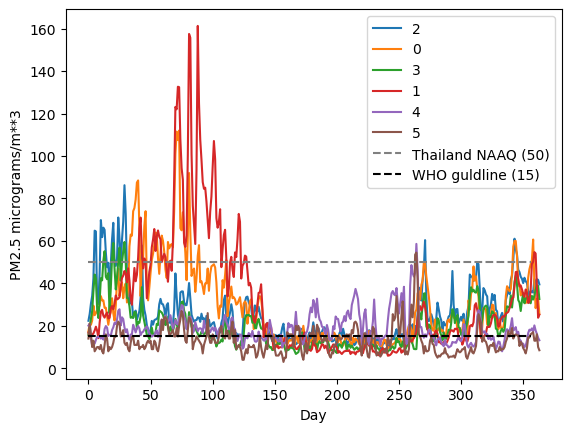

Year:  2020


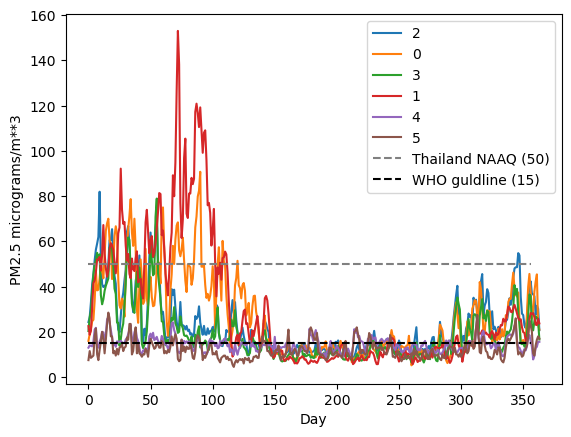

Year:  2021


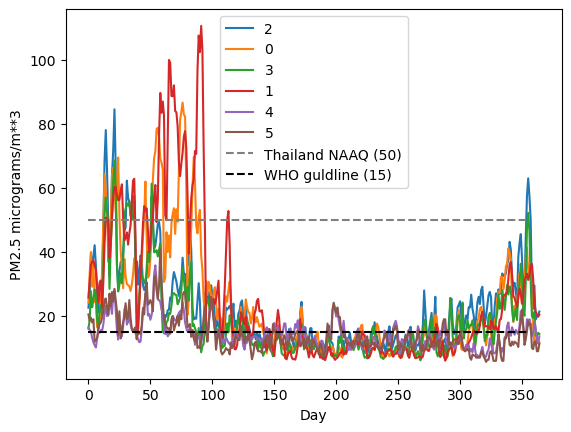

Year:  2022


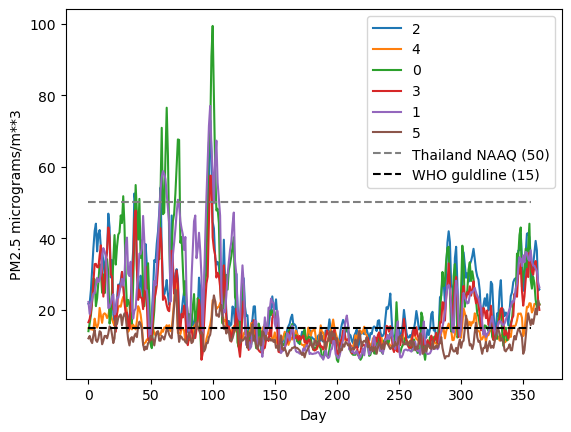

In [22]:
label_path = './check_station_per_provide.csv'
label_df = meteorology_labeling(label_path)
print('When be seperated by Thailand sector')
for year, df in PM_data.items():
    label_dict = match_label_station(df, label_df)
    print('Year: ', year)
    plot_PM_mean_curve(label_dict)
    plt.pause(0.0001)

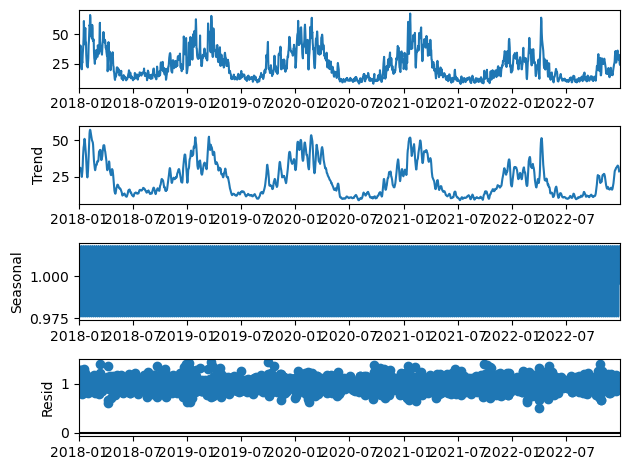

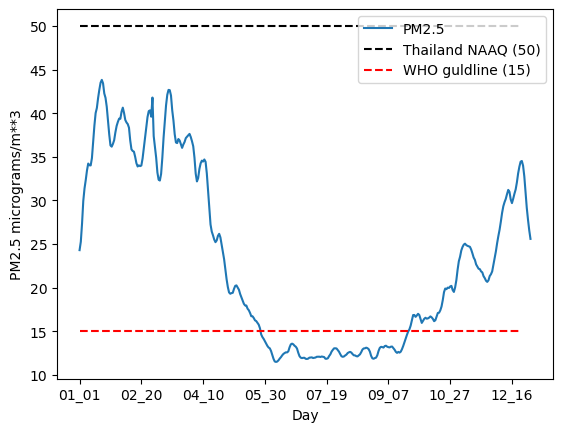

In [23]:
plot_TS_all_year(TS_PM_data, plot_result=True)

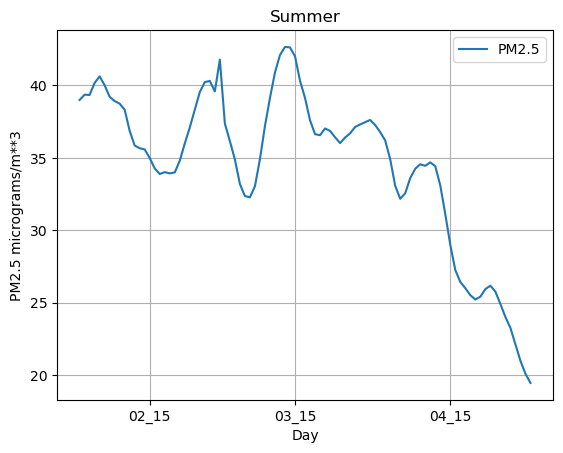

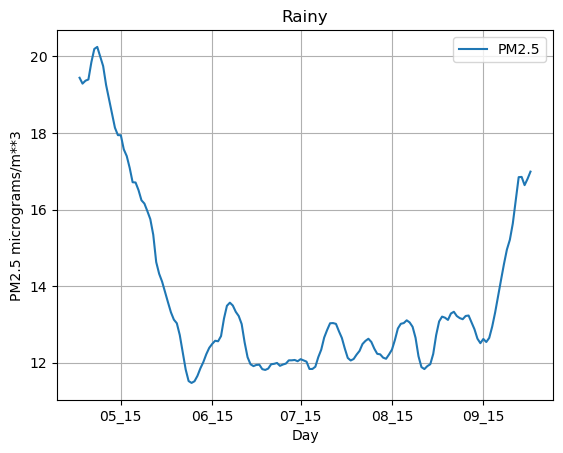

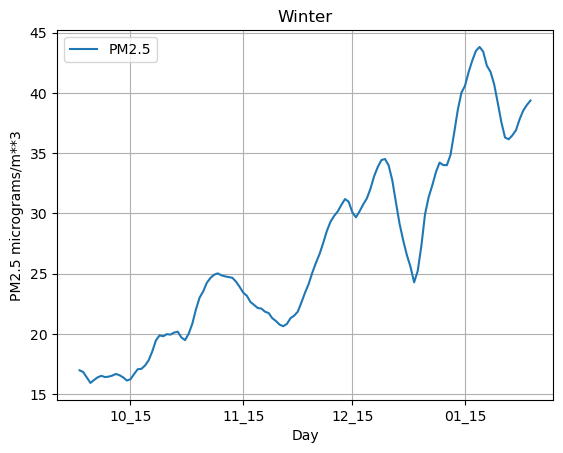

In [24]:
plot_TS_3_seasons(TS_PM_data)